In [1]:
import numpy as np
import random 
import pandas as pd
import os
import time
import csv 
import warnings

# MATH and STATS:
import math

# PLOT:
import matplotlib.pyplot as plt
from plotnine import *
from plotnine.data import *
%matplotlib inline

# SKLEARN:
from sklearn import metrics # AMII and ARI
from sklearn import decomposition #PCA
from sklearn import discriminant_analysis

# EMBEDDINGs:
import umap

In [71]:
from scipy import stats, special, optimize

In [3]:
from import_subset_datasets import *
from clustering_accuracy import acc

In [4]:
def lda_grid(em, mapper):
    AA, BB = np.meshgrid(np.linspace(em.A.min(), em.A.max(), 50),
                     np.linspace(em.B.min(), em.B.max(), 50))
    return AA, BB, mapper.inverse_transform(np.c_[AA.ravel(), BB.ravel()])

In [5]:
def plot_contours(gg, lda, AA, BB, grid):
    print(grid.shape)
    cmaps = ['Reds','Greens','Blues','Purples','Oranges']
    cnt = lda.predict_proba(grid)
    fig = gg.draw()
    ax = fig.get_axes()[0]
    for i in range(cnt.shape[1]):
        ax.contour(AA, BB, cnt[:,i].reshape(AA.shape), cmap=cmaps[i])#, [0.5])

In [6]:
def plot_regions(gg, lda, AA, BB, grid):
    colors = ['r','g','b','c','y']
    preds = lda.predict(grid)
    cnt = lda.predict_proba(grid)
    u = np.unique(preds)
    fig = gg.draw()
    ax = fig.get_axes()[0]
    grid_size = 50
    #pix_size = 
    plt.imshow(preds.reshape(grid_size,-1), extent=[AA.min(),AA.max(),BB.max(),BB.min()],cmap='gray')
    return
    for i in range(grid_size):
        for j in range(grid_size):
            ax.scatter(AA[i,j], BB[i,j], marker='s', ms=2, c=colors[np.where(preds[i*grid_size+j] == u)[0][0]])

In [7]:
np.random.seed(44)
random.seed(44)

read_mnist_train = pd.read_csv(r"data\mnist_train.csv")
read_mnist_test = pd.read_csv(r"data\mnist_test.csv")

In [8]:
mnist_labels_raw = read_mnist_train.iloc[:, 0]

mnist_data = read_mnist_train.iloc[:, 1:]

selected_digits = [3,6,8,9,4]
selected_digits_2 = [1,4]

mnist_pca, mnist_labels, mnist_raw, ve, pca = import_subset(mnist_data, mnist_labels_raw, selected_digits,30, 800)
mnist_pca_2, mnist_labels_2, mnist_raw_2, ve2, pca2 = import_subset(mnist_data, mnist_labels_raw, selected_digits_2, 30, 800)

In [9]:
# Transform test data
mnist_test_labels_raw = read_mnist_test.iloc[:, 0]
mnist_test_data = read_mnist_test.iloc[:, 1:]
mnist_test_pca, mnist_test_labels, mnist_test_raw,_,_2 = import_subset(mnist_test_data, mnist_test_labels_raw, selected_digits, 30, 400, pca=pca)

In [10]:
mapper = umap.UMAP(metric='euclidean')
embedding = mapper.fit_transform(mnist_pca)

label = pd.Series(mnist_labels)
em = pd.DataFrame(embedding, columns=['A','B']) 
em['label'] = label.astype(str)
gg = ggplot(aes(x='A', y='B', color='label'), data=em)+geom_point()+ scale_color_discrete(guide=False)+ labs(x = "", y = "") 
#gg.save("MNIST38_real.png",dpi =300)

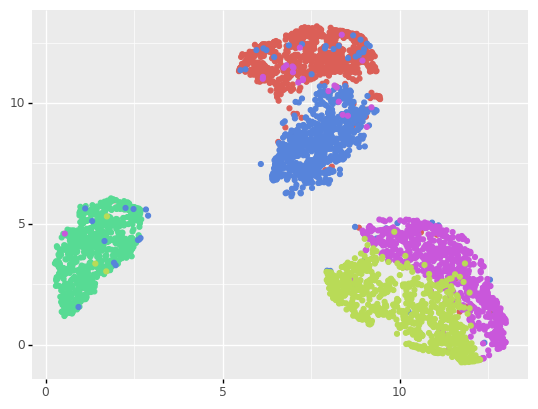

<ggplot: (168106228595)>

In [11]:
gg

In [12]:
nreps = 10

lda = discriminant_analysis.LinearDiscriminantAnalysis(store_covariance=True)
lda.fit(mnist_pca, label)

LinearDiscriminantAnalysis(store_covariance=True)

In [13]:
ret =  lda_grid(em, mapper)

(2500, 30)


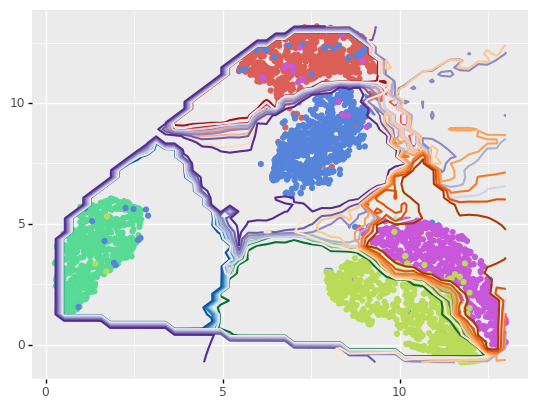

In [14]:
plot_contours(gg, lda, *ret)

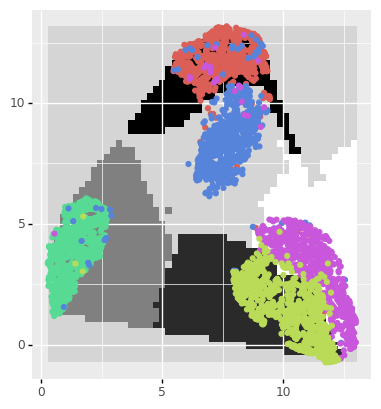

In [15]:
plot_regions(gg, lda, *ret)

In [16]:
print(acc(pd.Series(mnist_test_labels).astype(int), lda.predict(mnist_test_pca).astype(int)))
print(metrics.confusion_matrix(pd.Series(mnist_test_labels).astype(int), lda.predict(mnist_test_pca).astype(int)))

0.908
[[366   1   7  12  14]
 [  0 368   5   3  24]
 [  0   9 384   6   1]
 [ 20   9   8 349  14]
 [  8  31   3   9 349]]


In [164]:
class LDA():
    def __init__(self):
        self.ks = None #1xK
        self.priors = None #1xK
        self.coefficients = None #KxM
        self.intercepts = None #1xK
        self.parameters = None
        self.means = None #MxK
        self.covariance =  None #MxM
    
    def _discriminants(self, X): #NxM -> KxN
        assert((self.coefficients is not None) and (self.intercepts is not None) and (self.priors is not None))
        return self.coefficients.dot(X.T) + (self.intercepts + np.log(self.priors))[None,:].T
    
    def _kth_likelihood(self, k):
        return stats.multivariate_normal(mean=self.means[:,k], cov=self.covariance)
    
    def _posteriors(self, X):
        r = [self._kth_likelihood(k).pdf(X) for k in range(self.means.shape[1])]
        return np.array(r)
       
    def estimate_parameters(self, X): #NxM -> [1xM, MxM]
        return [X.mean(axis=0), np.cov(X.T)]
    
    def fit(self, X, y):
        self.ks = np.unique(y)
        classes = [X[np.where(y == k), :][0,:,:] for k in self.ks] #Kxn_kxM
        n = np.array([c.shape[0] for c in classes])
        self.parameters = [self.estimate_parameters(c) for c in classes]
        self.means = np.array([param[0] for param in self.parameters]).T
        self.covariance = np.sum(n[:,None,None] * np.array([param[1] for param in self.parameters]), axis=0) / n.sum()
        cov_inv = np.linalg.inv(self.covariance)
        
        self.coefficients = self.means.T.dot(cov_inv)
        self.intercepts = -0.5*np.diag(self.means.T.dot(cov_inv.dot(self.means)))
        self.priors = n / n.sum()
        
        assert(n.sum() == X.shape[0])
        assert (self.priors.sum() == 1)
    
    def predict(self, X):
        dk = self._discriminants(X)
        return self.ks[dk.argmax(axis=0)] 
    
    def predict2(self, X):
        dk = self._posteriors(X)
        return self.ks[dk.argmax(axis=0)] 

In [165]:
class t_LDA(LDA):
    def __init__(self):
        super().__init__()
        self.dofs = None #1xK
    
    def _kth_likelihood(self, k):
        stats.multivariate_t(loc=self.means[:,k], shape=self.covariance, df=self.dofs[k])
    
    def estimate_parameters(self, X):
        return fit_t(X)
    
    def fit(self, X,y):
        super().fit(X,y)
        self.dofs = np.array([param[2] for param in self.parameters])

In [166]:
test_t_LDA = t_LDA()

In [167]:
test_t_LDA.fit(mnist_pca, mnist_labels)

In [168]:
print(metrics.confusion_matrix(pd.Series(mnist_test_labels).astype(int), test_t_LDA.predict(mnist_test_pca).astype(int)))

[[366   1   6  14  13]
 [  0 368   5   3  24]
 [  0   9 383   7   1]
 [ 22   9   7 349  13]
 [  8  37   3  10 342]]


In [163]:
test_lda = LDA()

In [45]:
test_lda.fit(mnist_pca, mnist_labels)

In [46]:
print(metrics.confusion_matrix(pd.Series(mnist_test_labels).astype(int), test_lda.predict(mnist_test_pca).astype(int)))

[[366   1   7  12  14]
 [  0 368   5   3  24]
 [  0   9 384   6   1]
 [ 20   9   8 349  14]
 [  8  31   3   9 349]]


In [47]:
print(metrics.confusion_matrix(pd.Series(mnist_test_labels).astype(int), test_lda.predict2(mnist_test_pca).astype(int)))

[[366   1   7  12  14]
 [  0 368   5   3  24]
 [  0   9 384   6   1]
 [ 20   9   8 349  14]
 [  8  31   3   9 349]]


In [39]:
a = test_lda._posteriors(mnist_test_pca)

In [40]:
b = test_lda._discriminants(mnist_test_pca)

In [157]:
def fit_t(X, iter=200, eps=1e-6):
    N,D = X.shape
    cov = np.cov(X,rowvar=False)
    mean = X.mean(axis=0)
    mu = X - mean[None,:]
    dof = 3
    obj = []

    for i in range(iter):        
        
        # E step
        delta = np.einsum('ij,ij->i', mu, np.linalg.solve(cov,mu.T).T)
        z = (dof + D) / (dof + delta)
        
        obj.append(
            -N*np.linalg.slogdet(cov)[1]/2 - (z*delta).sum()/2 \
            -N*special.gammaln(dof/2) + N*dof*np.log(dof/2)/2 + dof*(np.log(z)-z).sum()/2)
        if len(obj) > 1 and np.abs(obj[-1] - obj[-2]) < eps: break
        
        # M step
        mean = (X * z[:,None]).sum(axis=0).reshape(-1,1) / z.sum()
        mu = X - mean.squeeze()[None,:]
        cov = np.einsum('ij,ik->jk', mu, mu * z[:,None])/N
        d_t = (np.log(z) + special.digamma((dof + D)/2) - np.log((dof + D)/2) - z).sum()
        dof_obj = lambda v: -( -N*special.gammaln(v/2) + N*v*np.log(v/2)/2 + v*d_t/2 )
        dof_grad = lambda v: -(N/2 * (-special.digamma(v/2) + np.log(v/2) + 1) + d_t/2)        
        dof = optimize.minimize(dof_obj, dof, jac=dof_grad, bounds=[(0,None)]).x

    return mean.squeeze(), cov, dof

In [97]:
X = stats.multivariate_t(loc=np.array([1,1]), shape=np.array([[2.1, 0.3], [0.3, 1.5]]), df=3.5).rvs(size=10000)

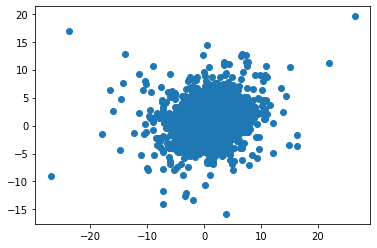

In [98]:
plt.scatter(X[:,0],X[:,1])

In [151]:
fit_t(X)

(array([[2.20393432, 0.33057396],
        [0.33057396, 1.60072226]]),
 array([0.99290467, 1.01694601]),
 array([3.62261971]))